<a href="https://colab.research.google.com/github/Yung-Huei/Python/blob/main/HW1_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/BIOS740/Homework/Homework 1

#!git clone https://github.com/RunpengDai/ICSA_DLcourse.git
#!git clone https://github.com/RunpengDai/BIOS740.git

Mounted at /content/drive
/content/drive/MyDrive/BIOS740/Homework/Homework 1


In [5]:
!pip install pytorch_lightning
import glob #讀取檔案路徑，例如找到所有.CSV檔
import pandas as pd #讀取表格資料（如 CSV）與 DataFrame 操作
import numpy as np #提供高效的陣列處理
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader #自訂數據集的類別/用來分批（batch）讀取資料，支援打亂、並行處理等功能
from sklearn.model_selection import train_test_split #用來將資料集依比例分成訓練集與測試集
import pytorch_lightning as pl #可以減少訓練時的 boilerplate code and 管理訓練流程、自動處理 GPU/TPU、記錄等。
from torchvision import models,transforms #圖像處理: 預訓練模型（如 ResNet、VGG）/資料預處理（如 resize、normalize、data augmentation）
import torchvision.transforms.functional as TF #例如隨機旋轉、裁切、水平翻轉
from pytorch_lightning.callbacks.early_stopping import EarlyStopping #提早停止訓練的回呼函數（Callback），如果驗證集的表現停止進步，就會自動停止訓練以避免 overfitting。
from pytorch_lightning.loggers import CSVLogger #將訓練過程的紀錄（如損失、準確率）寫入 .csv 檔，方便後續分析。
import matplotlib.pyplot as plt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 825.4/825.4 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 103.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 73.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 84.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 963.5/963.5 kB 45.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink

**Predicting Alzheimer's Disease Status Using Hippocampal Data**

阿茲海默症（Alzheimer's Disease, AD）是一種神經退化性疾病，其特徵為認知功能逐漸衰退。海馬迴的萎縮（hippocampus atrophy）是阿茲海默症早期的生物標記之一，而海馬迴是對記憶形成非常關鍵的大腦區域。

*   Source: ADNI資料庫
*   Sample Size: 369 位受試者的左側與右側海馬迴矩陣 (extracted from MRI scans)


    1.   Left Hippocampus Matrix: Dimensions 7x150x100 per subject.
    2.   Right Hippocampus Matrix: Dimensions 7x150x100 per subject.
    3.   Feature Description: radial distance from the medial model; the (log)determinant and two eigenvalues of the Jacobian matrix from the surface tensor-basedmorphometry (TBM) model (referred to as the determinant, eigenvalue1, and eigenvalue2); and three features from the multivariate surface TBM (mTBM) model (referred to as the mTBM1, mTBM2, and mTBM3.
    4.   AD Status Labels: A separate CSV file indicating the AD status (AD or Control) for each subject.


*   Format: 壓縮的 CSV 檔案
*   Method: CNN



In [ ]:
!ls
# # 複製 zip 檔案到 Colab 當前目錄
#!cp "/content/drive/MyDrive/BIOS740/Homework/Homework 1/HW1_data/LeftCSV.zip"
#!cp "/content/drive/MyDrive/BIOS740/Homework/Homework 1/HW1_data/RightCSV.zip"
#!ls

 adni_subset.csv   cnn-sol.ipynb    requirements.txt
'Chap3 HW.docx'    HW1_data	    RightCSV_subset
 cnn.ipynb	   LeftCSV_subset   selected_samples_subset.txt


In [ ]:
# Data Loading:
# Decompress and load the CSV files containing the hippocampal matrices.
# https://drive.google.com/drive/folders/1X1HPde-5snvjZhUyYKu5BHtqoJyCLrYb?usp=share_link

# 解壓縮
%cd /content/drive/MyDrive/BIOS740/Homework/Homework 1/HW1_data
!unzip -o RightCSV.zip -d "/content/drive/MyDrive/BIOS740/Homework/Homework 1/"
!unzip -o LeftCSV.zip -d "/content/drive/MyDrive/BIOS740/Homework/Homework 1/"
!ls
print("=========")
%cd /content/drive/MyDrive/BIOS740/Homework/Homework 1/
subject_ids = np.loadtxt("selected_samples_subset.txt", dtype=str)
left_hippo_dir = "LeftCSV_subset/"
left_hippo_files = glob.glob(left_hippo_dir+"*") #檔案路徑
right_hippo_dir = "RightCSV_subset/"
right_hippo_files = glob.glob(right_hippo_dir+"*")
labels = pd.read_csv("adni_subset.csv",names=['ID','AD'])
print(subject_ids[:5])
print(left_hippo_files[:3])

#Describe the dimensions and structure of the data.


/content/drive/.shortcut-targets-by-id/1X1HPde-5snvjZhUyYKu5BHtqoJyCLrYb/HW1_data
Archive:  RightCSV.zip
  inflating: /content/drive/MyDrive/BIOS740/Homework/Homework 1/RightCSV_subset/002_S_0295__2011-06-02__S110477.csv  
  inflating: /content/drive/MyDrive/BIOS740/Homework/Homework 1/RightCSV_subset/002_S_0413__2011-06-16__S111989.csv  
  inflating: /content/drive/MyDrive/BIOS740/Homework/Homework 1/RightCSV_subset/002_S_0685__2010-07-15__S89145.csv  
  inflating: /content/drive/MyDrive/BIOS740/Homework/Homework 1/RightCSV_subset/002_S_1261__2011-03-14__S101641.csv  
  inflating: /content/drive/MyDrive/BIOS740/Homework/Homework 1/RightCSV_subset/002_S_1280__2011-05-04__S108096.csv  
  inflating: /content/drive/MyDrive/BIOS740/Homework/Homework 1/RightCSV_subset/002_S_4213__2011-09-02__S121165.csv  
  inflating: /content/drive/MyDrive/BIOS740/Homework/Homework 1/RightCSV_subset/002_S_4225__2011-09-21__S122885.csv  
  inflating: /content/drive/MyDrive/BIOS740/Homework/Homework 1/RightC

In [ ]:
class HippocampusDataset(Dataset): #繼承自 torch.utils.data.Dataset，用來與 PyTorch 的 DataLoader 搭配使用。
    def __init__(self, left_hippo_files, right_hippo_files, labels=None): #建構函式 __init__ 建立這個類別的物件時會自動執行的函式。
        self.left_hippo = [pd.read_csv(f, header=None, sep=" ").values for f in left_hippo_files] #讀取檔案/ .values：轉成 NumPy array
        self.right_hippo = [pd.read_csv(f, header=None, sep=" ").values for f in right_hippo_files]
        self.labels = labels['AD'] if labels is not None else None

    def __len__(self): #傳回資料筆數 __len__想讓 len(obj) 有效果
        return len(self.left_hippo)

    def __getitem__(self, idx): #回傳第 idx 筆資料（模型訓練時會呼叫）
        left = self.left_hippo[idx].astype(np.float32)  # shape: (15000, 7) #GPU 運算（如 CUDA）對 float32 支援更好、更快
        right = self.right_hippo[idx].astype(np.float32) # shape: (15000, 7) # 是 NumPy 的陣列（np.ndarray）非tensor

        ##########################################################
        # 1. Concatenate the left and right hippocampus data along the feature dimension => (15000, 14)
        # 2. Transpose to get (14, 15000)
        # 3. Reshape each feature into (14, 150, 100)
        # 4. Convert to torch tensor and normalize per feature channel
        ##########################################################

        # Step 1: Concatenate
        sample = np.concatenate((left, right), axis=1)  # (15000, 14) # axis=0 垂直拼接 反之水平拼接

        # Step 2: Transpose
        sample = sample.T  # (14, 15000)

        # Step 3: Reshape each feature to (14, 150, 100)
        sample = sample.reshape(14, 150, 100)
        # sample = sample[[0, 7], :, :]

        # Step 4a: Convert to PyTorch tensor
        sample = torch.tensor(sample, dtype=torch.float32)  # (14, 150, 100) # NumPy 陣列--> PyTorch 需要的是自己的資料結構(主要是cuda只支援torch.float32)

        # Step 4b: Normalize each feature channel
        mean = sample.mean(dim=(1, 2), keepdim=True)  # shape: (14, 1, 1)
        std = sample.std(dim=(1, 2), keepdim=True)    # shape: (14, 1, 1)
        sample = (sample - mean) / (std + 1e-8)       # add epsilon to avoid /0

        ##########################################################
        # END OF YOUR CODE
        ##########################################################

        if self.labels is not None:
            label = self.labels.iloc[idx]
            return sample, label
        else:
            return sample


The training set contain 236 samples.
Each sample has shape torch.Size([14, 150, 100]).


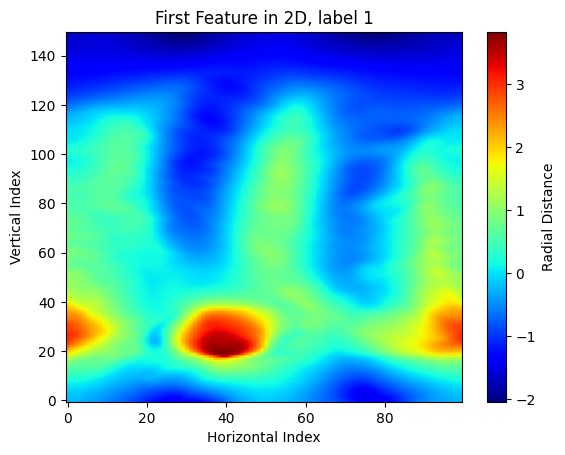

In [ ]:
#subject_ids + 左右腦影像路徑
data_df = pd.DataFrame({
    'ID': subject_ids,
    'LeftFile': left_hippo_files,
    'RightFile': right_hippo_files
})

# Merge data and labels on SubjectID
merged_df = pd.merge(data_df, labels, on='ID', how='inner')  # on: 指定要根據哪一個欄位進行合併。
                                  # how: "inner" 只保留「兩邊都有」的 ID（交集） Keep only subjects with labels
# Now extract the filtered lists
filtered_left_files = merged_df['LeftFile'].tolist() #左右腦路徑清單
filtered_right_files = merged_df['RightFile'].tolist()

unique_labels = sorted(set(labels['AD'])) #set 會取出不重複的標籤（集合）
label_to_index = {label: idx for idx, label in enumerate(unique_labels)} #創一個字典
labels['AD'] = [label_to_index[label] for label in labels['AD']]

# Split into training and validation sets
train_left, test_left, train_right, test_right, train_labels, test_labels = train_test_split(
    filtered_left_files, filtered_right_files, labels, test_size=0.2, random_state=42
)

train_left, val_left, train_right, val_right, train_labels, val_labels = train_test_split(
    train_left, train_right, train_labels, test_size=0.2, random_state=42
)

# Create Datasets and DataLoaders
train_dataset = HippocampusDataset(train_left, train_right, train_labels)
val_dataset = HippocampusDataset(val_left, val_right, val_labels)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

test_dataset = HippocampusDataset(test_left, test_right, test_labels)
test_loader = DataLoader(test_dataset, batch_size=32)

# visualize some samples
print(f"The training set contain {len(train_dataset)} samples.")
print(f"Each sample has shape {train_dataset[0][0].shape}.")

example_rd_tensor = train_dataset[0][0][0]  #train_dataset[0] == (sample_tensor, label)
                        #train_dataset[0][0] == sample_tensor (14*150*100)
                        #train_dataset[0][0][0]-->(150, 100)
# Convert to NumPy
radial_distance = example_rd_tensor.cpu().numpy() #把 tensor 搬回 CPU	轉成 NumPy 陣列（方便視覺化、處理）

# Then plot as before
plt.imshow(radial_distance, origin='lower', cmap='jet', aspect='auto') # aspect="auto" 不保證是正方形像素
plt.colorbar(label="Radial Distance")
plt.title(f"First Feature in 2D, label {train_dataset[0][1]}")
plt.xlabel("Horizontal Index")
plt.ylabel("Vertical Index")
plt.show()


In [11]:
## Naive CNN model
### First we create a trainer

class Trainer(pl.LightningModule):
    def __init__(self, model = None):
        super(Trainer, self).__init__() # 去呼叫 LightningModule 的初始化方法
        self.model = model
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx): #batch：由 DataLoader 傳進來的一個小批次資料，通常是一個 (data, label) 的 tuple。
                          #batch_idx：這是目前是第幾個 batch（從 0 開始）。你這段程式碼沒用到它，但 Lightning 會傳給你。
        data, labels = batch #拆分
        outputs = self(data)  # 如果你繼承 nn.Module 並定義一個類別（例如你的 Trainer），系統會自動幫你定義 __call__ 方法
                     # def __call__(self, *args, **kwargs):
                     # 做一些準備（例如 hook、hook logging）
                     # return self.forward(*args, **kwargs)
                     # 因此等價於 outputs = self.forward(data)
        loss = self.criterion(outputs, labels)
        preds = torch.argmax(outputs, dim=1) # 在dim=0(欄)維度上找最大值
        acc = (preds == labels).float().mean() # 這個batch分類的準確率
        self.log('train_loss', loss) # 自動記錄訓練 loss 與準確率
        self.log('train_acc', acc)
        return loss # 自動做 .backward()（反向傳播）
               # 自動做 optimizer.step()（參數更新）

    def validation_step(self, batch, batch_idx):
        data, labels = batch
        outputs = self(data)
        loss = self.criterion(outputs, labels)
        preds = torch.argmax(outputs, dim=1)
        acc = (preds == labels).float().mean()
        self.log('val_loss', loss)
        self.log('val_acc', acc)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-4)


In [ ]:
def calculate_output_shape(height, width):
    """
    Helper to compute output (height, width) after convolution block
    """
    for _ in range(3): # 重複做 3 次，不在意每次的變數值
        # Conv layer
        height = ((height + 2*1 - (3 - 1) - 1) // 1) + 1
        width  = ((width  + 2*1 - (3 - 1) - 1) // 1) + 1
        # Pool layer
        height = ((height - (2 - 1) - 1) // 2) + 1
        width  = ((width  - (2 - 1) - 1) // 2) + 1

    return height, width
calculate_output_shape(150, 100)

(18, 12)

In [7]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(SimpleCNN, self).__init__()
        ##########################################################
        # 1) Three 2D convolutional layers
        # 2) A MaxPool2d layer self.pool
        # 3) A Dropout layer self.dropout with probability 0.5
        # 4) Two fully connected layers
        #    -> Remember to compute in_features for self.fc1 based on
        #       the output shape after the Conv+Pool layers.
        ##########################################################

        # Conv2d: in_channels=14  (since your data has shape [B, 14, 150, 100])
        #          out_channels=32/64/128
        #          kernel_size=3, stride=1, padding=1 (typical “same” conv)
        self.conv1 = nn.Conv2d(in_channels=14, out_channels=32,
                               kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64,
                               kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128,
                               kernel_size=3, stride=1, padding=1)

        # MaxPool2d: kernel_size=2, stride=2
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Dropout
        self.dropout = nn.Dropout(p=0.5)

        # Compute the spatial output size after 3 conv+pool layers
        out_h, out_w = 18, 12

        # Fully Connected layers
        # After the last conv/pool, you have 128 channels with size out_h x out_w
        self.fc1 = nn.Linear(in_features=128 * out_h * out_w, out_features=64)
        self.fc2 = nn.Linear(in_features=64, out_features=2)

        ##########################################################
        # END OF YOUR CODE
        ##########################################################

    def forward(self, x):
        """
        Forward pass:
        x shape = [batch_size, 14, 150, 100]
        """
        # 1) First conv + ReLU + pool
        x = F.relu(self.conv1(x))  # [B, 32, 150, 100]
        x = self.pool(x)           # [B, 32,  75,  50]

        # 2) Second conv + ReLU + pool
        x = F.relu(self.conv2(x))  # [B, 64,  75,  50]
        x = self.pool(x)           # [B, 64,  37,  25]

        # 3) Third conv + ReLU + pool
        x = F.relu(self.conv3(x))  # [B, 128, 37,  25]
        x = self.pool(x)           # [B, 128, 18,  12]

        # Flatten
        x = x.view(x.size(0), -1)  # [B, 128*18*12]
        x = self.dropout(x)

        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x.squeeze()

In [8]:
x = torch.randn(1, 14, 150, 100)
simple_cnn = SimpleCNN()
simple_cnn(x)

tensor([0.0666, 0.0112], grad_fn=<SqueezeBackward0>)

In [9]:
class FinalPlotCallback(pl.Callback):
    def __init__(self):
        super().__init__()
        self.train_losses = []
        self.val_losses = []

    def on_train_epoch_end(self, trainer, pl_module):
        # Append training and validation loss at the end of each epoch
        train_loss = trainer.callback_metrics.get("train_loss")
        if train_loss:
            self.train_losses.append(train_loss.cpu().detach().item())

        val_loss = trainer.callback_metrics.get("val_loss")
        if val_loss:
            self.val_losses.append(val_loss.cpu().detach().item())

    def on_train_end(self, trainer, pl_module):
        # Plot the losses at the end of training
        plt.figure(figsize=(10, 5))
        plt.plot(self.train_losses, label="Train Loss", marker="o")
        plt.plot(self.val_losses, label="Validation Loss", marker="o")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Training and Validation Loss Over Epochs")
        plt.legend()
        plt.grid(True)
        plt.show()

In [12]:
model = Trainer(model=SimpleCNN())
# Trainer
trainer =  pl.Trainer(max_epochs=50, callbacks=[FinalPlotCallback()]) # You may check the documents
# Training
trainer.fit(model, train_loader, val_loader)

INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


NameError: name 'train_loader' is not defined

In [4]:
x = torch.randn(1, 14, 150, 100)
simple_cnn = SimpleCNN()
simple_cnn(x)

NameError: name 'torch' is not defined

In [ ]:
class FinalPlotCallback(pl.Callback):
    def __init__(self):
        super().__init__()
        self.train_losses = []
        self.val_losses = []

    def on_train_epoch_end(self, trainer, pl_module):
        # Append training and validation loss at the end of each epoch
        train_loss = trainer.callback_metrics.get("train_loss")
        if train_loss:
            self.train_losses.append(train_loss.cpu().detach().item())

        val_loss = trainer.callback_metrics.get("val_loss")
        if val_loss:
            self.val_losses.append(val_loss.cpu().detach().item())

    def on_train_end(self, trainer, pl_module):
        # Plot the losses at the end of training
        plt.figure(figsize=(10, 5))
        plt.plot(self.train_losses, label="Train Loss", marker="o")
        plt.plot(self.val_losses, label="Validation Loss", marker="o")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Training and Validation Loss Over Epochs")
        plt.legend()
        plt.grid(True)
        plt.show()

In [ ]:
model = Trainer(model=SimpleCNN())
# Trainer
trainer =  pl.Trainer(max_epochs=50, callbacks=[FinalPlotCallback()]) # You may check the documents
# Training
trainer.fit(model, train_loader, val_loader)

In [1]:
def testing(model):
    # Inference on Test Set
    model.eval()
    test_label = test_labels['AD']
    test_preds = []
    with torch.no_grad():
        for batch in test_loader:
            data, _ = batch  # Unpack the batch; labels are ignored
            outputs = model(data)
            predictions = torch.argmax(outputs, dim=1)
            test_preds.extend(predictions.cpu().numpy())
    ##########################################################
    # TODO: Import the necessary evaluation metrics from sklearn.metrics:
    # - accuracy_score
    # - precision_score
    # - recall_score
    # - f1_score
    # - roc_auc_score
    #
    # Then, compute the following metrics using `test_label` and `test_preds`:
    # 1. Accuracy
    # 2. Precision (use 'weighted' average)
    # 3. Recall (use 'weighted' average)
    # 4. F1-Score (use 'weighted' average)
    # 5. ROC-AUC (use 'weighted' average and 'ovr' for multi_class)
    #
    # Finally, print out each metric with four decimal places in the specified format.
    ##########################################################
    # Replace "pass" statement with your code

    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

    accuracy = accuracy_score(test_label, test_preds)
    precision = precision_score(test_label, test_preds, average='weighted')
    recall = recall_score(test_label, test_preds, average='weighted')
    f1 = f1_score(test_label, test_preds, average='weighted')
    roc_auc = roc_auc_score(test_label, test_preds, multi_class='ovr', average='weighted')

    print(f'Test Accuracy: {accuracy:.4f}')
    print(f'Test Precision: {precision:.4f}')
    print(f'Test Recall: {recall:.4f}')
    print(f'Test F1-Score: {f1:.4f}')
    print(f'Validation ROC-AUC: {roc_auc:.4f}')

    ##########################################################
    # END OF YOUR CODE
    ##########################################################

In [2]:
testing(model)

NameError: name 'model' is not defined